# Imports

In [1]:
%load_ext tensorboard
%matplotlib notebook

In [2]:
import torchio as tio
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

from model import UNet
from model2 import Segmenter

from IPython.display import HTML
from celluloid import Camera

In [3]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

## Load Images

In [5]:
path = Path("Liver/imagesTr/")
subject_paths = list(path.glob("liver*"))# Choose a subject
subjects = []

for subject_path in subject_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"CT":tio.ScalarImage(subject_path), "Label":tio.LabelMap(label_path)})
    subjects.append(subject)

In [6]:
for subject in subjects:
    assert subject["CT"].orientation == ("R", "A", "S")

## Dataset

In [7]:
process = tio.Compose([
            tio.CropOrPad((256, 256, 200)),
            tio.RescaleIntensity((-1, 1))
            ])
val_transform = process
val_dataset = tio.SubjectsDataset(subjects[105:], transform=val_transform)

## Evaluation

Dice score object will be used for the mesure the accuracy of the model.

In [8]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()     
        denum = pred.sum() + mask.sum() + 1e-8
        dice = (2*counter)/denum
        
        return dice

First we load the model and place it on the gpu if possible

In [9]:
model = Segmenter.load_from_checkpoint("weights/epoch=96-step=25511.ckpt")
model = model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

### Patch Aggregation
The model was trained in a patch wise manner as the full volumes are too large to be placed on a typical GPU.
But we still want to get a result for the whole volume.<br />
torchio helps us doing so by performing *Patch Aggregation*

The goal of patch aggregation is to split the image into patches, then compute the segmentation for each patch and finally merge the predictions into the prediction for the full volume.

The pipeline is as follows:
1. Define the **GridSampler(subject, patch_size, patch_overlap)** responsible for dividing the volume into patches. Each patch is defined by its location accesible via *tio.LOCATION*
2. Define the **GridAggregator(grid_sampler)** which merges the predicted patches back together
3. Compute the prediction on the patches and aggregate them via **aggregator.add_batch(pred, location)**
4. Extract the full prediction via **aggregator.get_output_tensor()**

Additionally, we can leverage the DataLoader from pytorch to perform the prediction in a batch wise manner for a nice speed up

In [10]:
IDX = 0
mask = val_dataset[IDX]["Label"]["data"]
imgs = val_dataset[IDX]["CT"]["data"]

# GridSampler
grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8, 8, 8))


In [11]:
# GridAggregator
aggregator = tio.inference.GridAggregator(grid_sampler)

In [12]:
# DataLoader for speed up
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=2)

In [13]:
# Prediction
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch['CT']["data"].to(device)  # Get batch of patches
        locations = patches_batch[tio.LOCATION]  # Get locations of patches
        pred = model(input_tensor)  # Compute prediction
        aggregator.add_batch(pred, locations)  # Combine predictions to volume

In [14]:
# Extract the volume prediction
output_tensor = aggregator.get_output_tensor()  
print(output_tensor.shape)

torch.Size([3, 256, 256, 200])


<IPython.core.display.Javascript object>


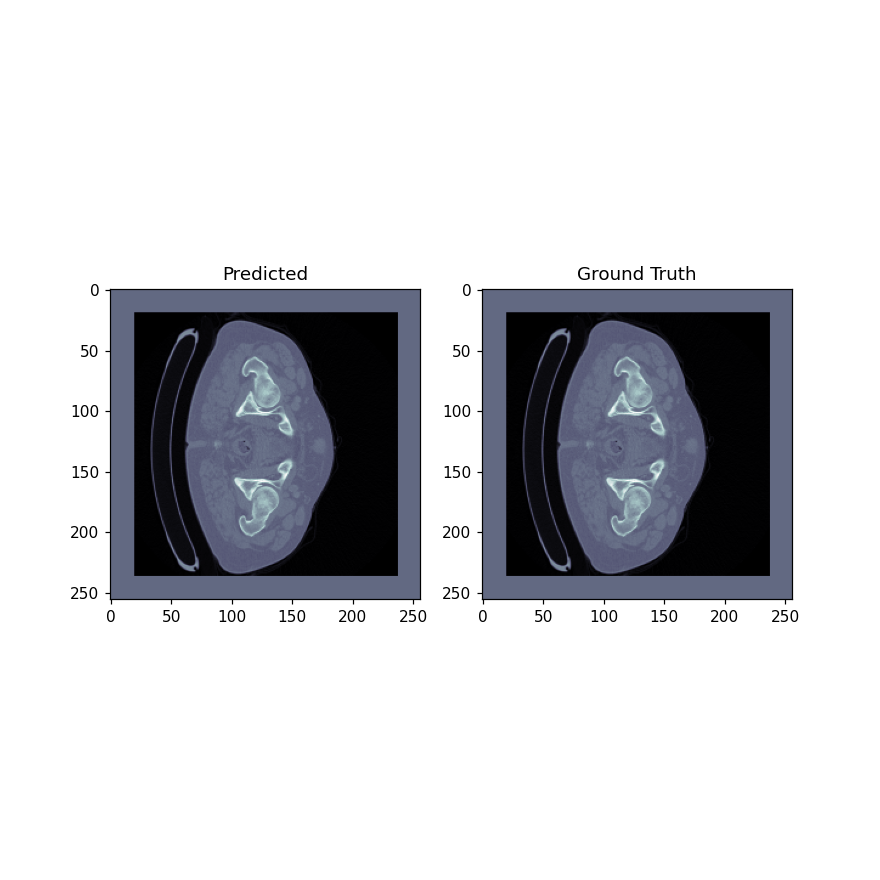

The Val Dice Score is: 0.9692615270614624


In [19]:
fig, axis = plt.subplots(1, 2, figsize = (8, 8))
camera = Camera(fig)  # create the camera object from celluloid

pred = output_tensor.argmax(0)

dice_score = DiceScore()((pred > 0.5), (mask.squeeze(0) > 0.5).float())
print(f"The Val Dice Score is: {dice_score}")

for i in range(0, output_tensor.shape[3], 2):  
    axis[0].imshow(imgs[0,:,:,i], cmap="bone")
    axis[1].imshow(imgs[0,:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,:,i]==0, pred[:,:,i])
    label_mask = np.ma.masked_where(mask[0,:,:,i]==0, mask[0,:,:,i])
    axis[0].imshow(mask_, alpha=0.4, cmap="autumn")
    axis[1].imshow(label_mask, alpha=0.4) 
    axis[0].set_title("Predicted")
    axis[1].set_title("Ground Truth")
    
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [16]:
HTML(animation.to_html5_video())  # convert the animation to a video


In [17]:
%tensorboard --logdir=./ --port=6005

Reusing TensorBoard on port 6005 (pid 11560), started 20:49:47 ago. (Use '!kill 11560' to kill it.)